In [47]:
import sys
sys.path.append("../script")
from data_preparation import *
import pandas as pd
from patsy import dmatrices
import statsmodels.formula.api as smf

# Import et préparation des données

In [89]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [3]:
dataprep = DataPreparation(train, test, 0.3)

In [4]:
train_prepared, test_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 12/12 [05:36<00:00, 28.05s/it]

Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [8]:
df_train = train_prepared.copy()

# Modélisation

In [23]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

In [19]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [84]:
def calculate_percentage_default(row, data_frame):
    variable = row['Variable']
    modality = row['Modality']
    if modality.isdigit() :
        modality = int(modality)

    default_count = data_frame[data_frame[variable] == modality]["TARGET"].sum()
    total_count = data_frame.shape[0]
    return round((default_count / total_count)*100,2)

def calculate_pcentage_class(row, data_frame):
    variable = row['Variable']
    modality = row['Modality']
    if modality.isdigit() :
        modality = int(modality)

    default_count = data_frame[data_frame[variable] == modality].shape[0]
    total_count = data_frame.shape[0]
    return round((default_count / total_count)*100,2)

In [88]:
formula = 'TARGET ~ C(FLAG_EMP_PHONE) + C(REG_CITY_NOT_LIVE_CITY) + C(EXT_SOURCE_2_disc_int)'
model = smf.logit(formula=formula, data=df_train)
logit_model = model.fit()

results_summary_frame = logit_model.summary2().tables[1]

coefs = results_summary_frame['Coef.']
p_values = results_summary_frame['P>|z|']

max_coef = coefs.loc[coefs.index != 'Intercept'].max()
min_coef = coefs.loc[coefs.index != 'Intercept'].min()

score_card = pd.DataFrame(columns=['Variable', 'Coefficient', 'P-Value', 'Score'])

for variable in coefs.index[1:]:  
    coef = round(coefs[variable],2)
    p_value = round(p_values[variable],4)
    score = round(abs(max_coef - coef) / (max_coef - min_coef) * 1000, 2)
    
    score_card.loc[len(score_card)] = [variable, coef, p_value, score]

score_card['Normalized Score'] = round((score_card['Score'] - score_card['Score'].min()) / (score_card['Score'].max() - score_card['Score'].min()) * 1000,2)

score_card["Modality"] = score_card["Variable"].apply(lambda x: x.split("[T.")[1][:-1])
score_card["Variable"] = score_card["Variable"].apply(lambda x: (x.split("C(")[1]).split(")")[0])

score_card["Pcentage_Défaut"] = score_card.apply(lambda row: calculate_percentage_default(row, df_train), axis=1)
score_card["Pcentage_Classe"] = score_card.apply(lambda row: calculate_pcentage_class(row, df_train), axis=1)


score_card = score_card[['Variable', "Modality", 'Coefficient', 'P-Value', 'Normalized Score', "Pcentage_Défaut", "Pcentage_Classe"]]

score_card

Optimization terminated successfully.
         Current function value: 0.257106
         Iterations 7


,Variable,Modality,Coefficient,P-Value,Normalized Score,Pcentage_Défaut,Pcentage_Classe
0,FLAG_EMP_PHONE,1,0.51,0.0,0.00,6.65,81.94
1,REG_CITY_NOT_LIVE_CITY,1,0.41,0.0,48.51,0.91,7.81
2,EXT_SOURCE_2_disc_int,[0.16-0.46],-0.72,0.0,617.39,2.73,25.60
3,EXT_SOURCE_2_disc_int,[0.46-0.85],-1.48,0.0,1000.00,3.62,68.30


In [57]:
import numpy as np

def calculate_contributions(N_scores, r_proportions, k_variables):
    """
    Calculate the contribution of modalities for each variable.

    Parameters:
    - N_scores: A dictionary where keys are variables and values are lists of tuples with the modality score and its average.
    - r_proportions: A dictionary where keys are variables and values are lists of the population proportion for each modality.
    - k_variables: The number of variables in the model.

    Returns:
    A dictionary with the contribution of each modality for each variable.
    """
    contributions = {}
    for variable, scores in N_scores.items():
        # Calculate average score for the variable
        N_bar = np.mean([score[0] for score in scores])

        # Calculate the numerator for the variable's contribution
        numerator = np.sqrt(sum([r_proportions[variable][j] * (score[0] - N_bar) ** 2 for j, score in enumerate(scores)]))
        
        # Calculate the denominator for the variable's contribution
        denominator = np.sqrt(sum([
            sum([r_proportions[var][j] * (score[0] - np.mean([s[0] for s in N_scores[var]])) ** 2
                 for j, score in enumerate(N_scores[var])])
            for var in N_scores
        ]))
        
        # Calculate contributions for each modality
        contributions[variable] = [numerator / denominator for score in scores]

    return contributions

# Example usage:
# Assuming you have calculated the N_scores and r_proportions for each variable
N_scores = {
    'variable1': [(100, 90), (200, 180)], 'variable2': [(30, 120), (100, 90)], # example (score, average score) for each modality
    # ... other variables
}
r_proportions = {
    'variable1': [0.5, 0.5], 'variable2' : [0.2, 0.8]  # example population proportion for each modality
    # ... other variables
}
k_variables = 2  # example number of variables

contributions = calculate_contributions(N_scores, r_proportions, k_variables)
print(contributions)


{'variable1': [0.8192319205190405, 0.8192319205190405], 'variable2': [0.5734623443633283, 0.5734623443633283]}


In [105]:
train['OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].fillna(train["OCCUPATION_TYPE"].mode()[0])

In [104]:
train["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
Laborers                 54867
Sales staff              31924
Core staff               27468
Managers                 21300
Drivers                  18486
High skill tech staff    11330
Accountants               9783
Medicine staff            8506
Security staff            6678
Cooking staff             5912
Cleaning staff            4621
Private service staff     2641
Low-skill Laborers        2072
Waiters/barmen staff      1337
Secretaries               1300
Realty agents              748
HR staff                   560
IT staff                   525
Name: count, dtype: int64

In [106]:
list_mean = []
for cat in train['OCCUPATION_TYPE'].unique():
    moyenne = train[train['OCCUPATION_TYPE']==cat]['TARGET'].mean()
    list_mean.append(moyenne)
    
motif = pd.DataFrame(list_mean, columns=['moyenne'])
motif['family'] = train['OCCUPATION_TYPE'].unique()
motif.sort_values(ascending=False, by = 'moyenne', inplace=True)
motif.dropna(inplace=True)
motif.reset_index(drop=True, inplace=True)
motif

,moyenne,family
0,0.163127,Low-skill Laborers
1,0.107811,Drivers
2,0.105460,Waiters/barmen staff
3,0.101827,Security staff
4,0.099797,Cooking staff
5,0.091405,Sales staff
6,0.090240,Cleaning staff
7,0.076095,Laborers
8,0.074866,Realty agents
9,0.066923,Secretaries


In [97]:
specific = ["specific housing"]  
not_specific = ['terraced house', 'block of flats']

train['HOUSETYPE_MODE_discret'] = np.select(
    [
        train['HOUSETYPE_MODE'].isin(specific),
        train['HOUSETYPE_MODE'].isin(not_specific)
    ],
    ['specific', 'not_specific'],
    default='not_specific')

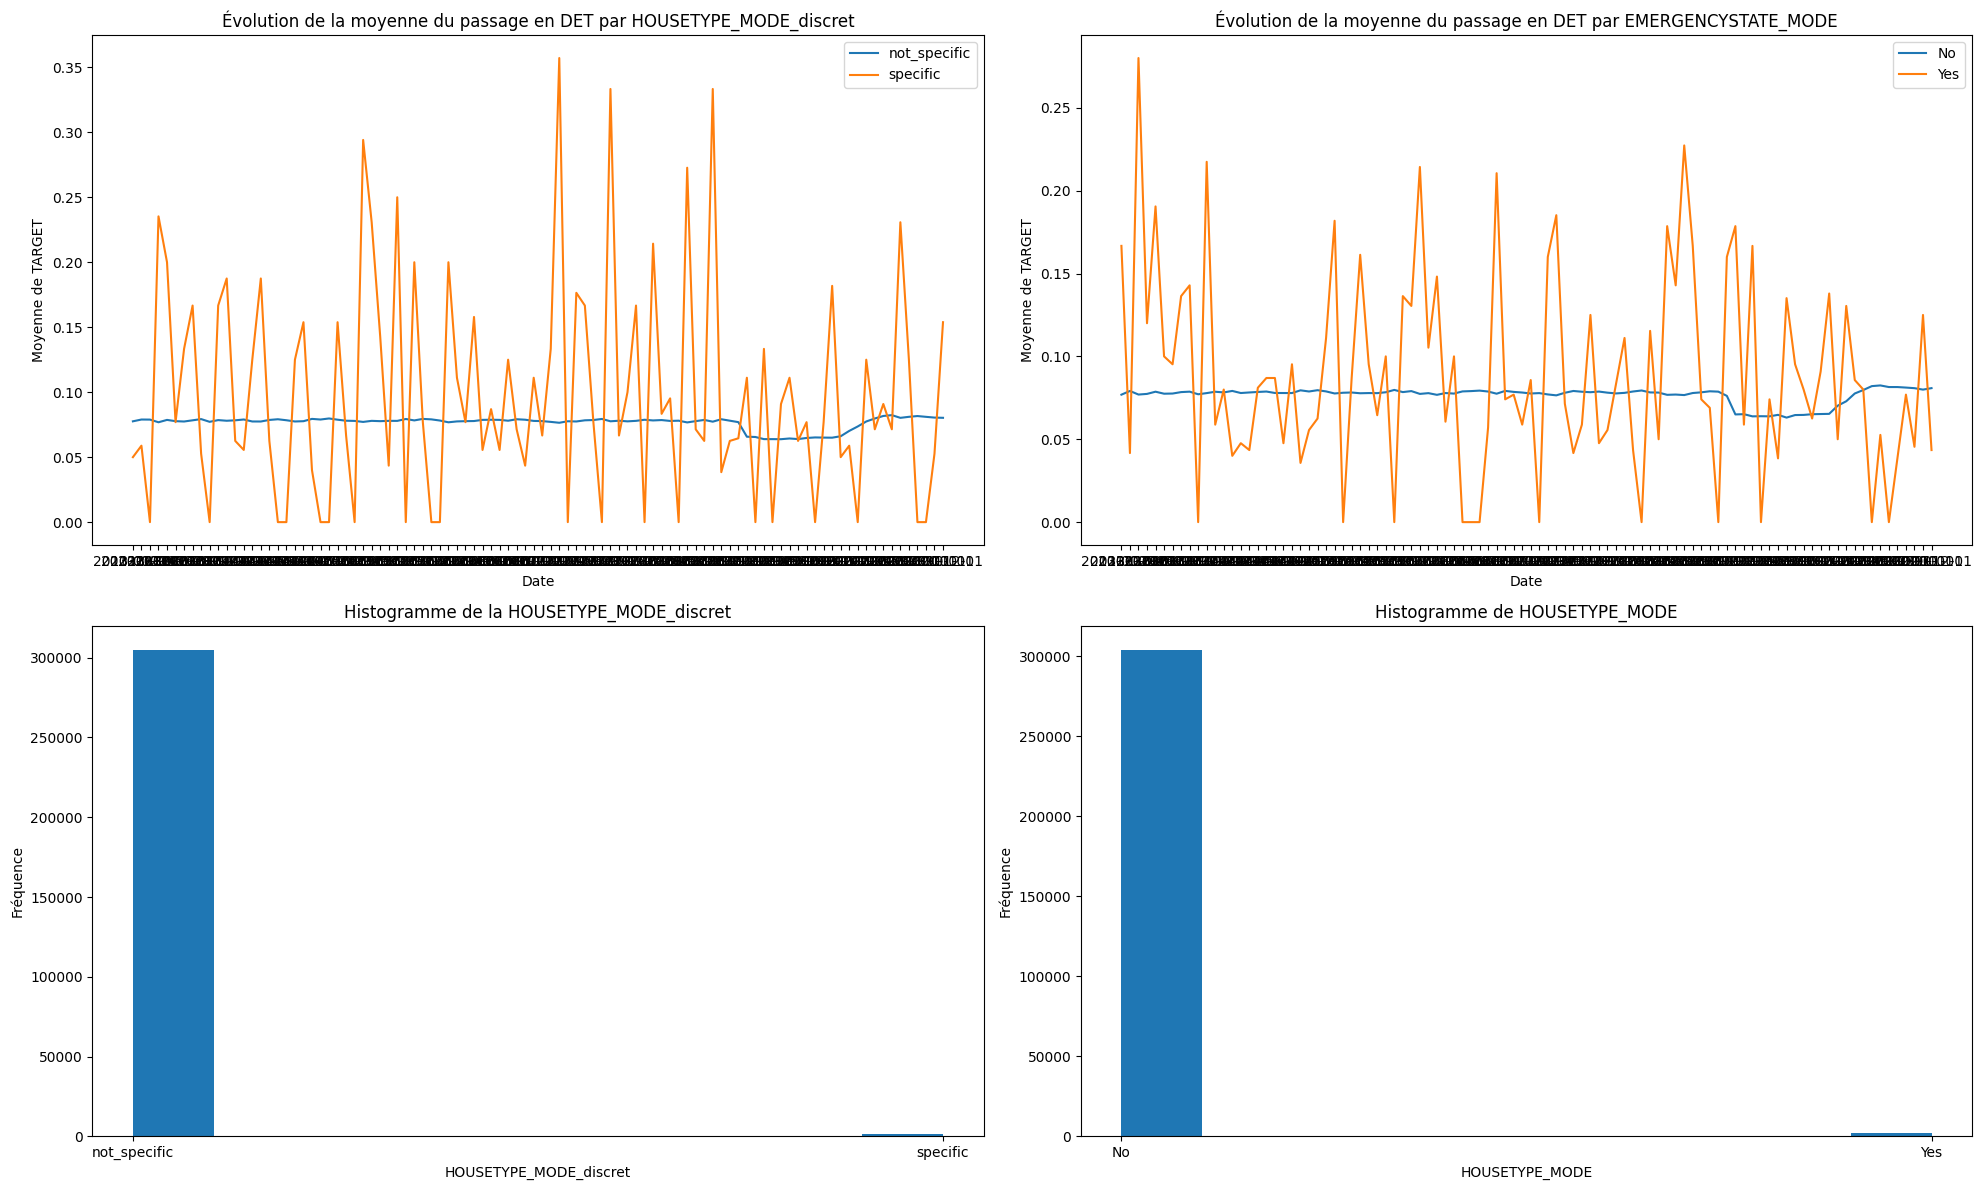

In [103]:
import matplotlib.pyplot as plt

# Création d'une grille de subplots avec 2 lignes et 2 colonnes
# Les deux premiers subplots (en haut) pour les courbes, et le troisième (en bas à gauche) pour l'histogramme
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

for idx, col in enumerate(train[['HOUSETYPE_MODE_discret', 'EMERGENCYSTATE_MODE']].columns):
    result = train.groupby([col, 'date_mensuelle'])['TARGET'].mean().reset_index()
   
    for genre, group in result.groupby(col):
        axes[0, idx].plot(group['date_mensuelle'], group['TARGET'], label=genre)
    
    axes[0, idx].legend()
    axes[0, idx].set_xlabel('Date')
    axes[0, idx].set_ylabel('Moyenne de TARGET')
    axes[0, idx].set_title(f'Évolution de la moyenne du passage en DET par {col}')

# Histogramme pour la 'NAME_TYPE_SUITE_discret' dans le troisième subplot (en bas à gauche)
axes[1, 0].hist(train["HOUSETYPE_MODE_discret"])
axes[1, 0].set_title('Histogramme de la HOUSETYPE_MODE_discret')
axes[1, 0].set_xlabel('HOUSETYPE_MODE_discret')
axes[1, 0].set_ylabel('Fréquence')

# Histogramme pour 'WALLSMATERIAL_MODE' dans le quatrième subplot (en bas à droite)
axes[1, 1].hist(train["EMERGENCYSTATE_MODE"].dropna())  # Utilisez dropna() pour exclure les valeurs NaN
axes[1, 1].set_title('Histogramme de HOUSETYPE_MODE')
axes[1, 1].set_xlabel('HOUSETYPE_MODE')
axes[1, 1].set_ylabel('Fréquence')
plt.tight_layout()
plt.show()

In [107]:
impute_0 = ["OWN_CAR_AGE", "EXT_SOURCE_1", "YEARS_BEGINEXPLUATATION_MEDI",
                     "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BEGINEXPLUATATION_AVG"]

for var in impute_0 :
    train[var].fillna(0, inplace = True)
    test[var].fillna(0, inplace=True)

In [108]:
dict_var = {
    "OWN_CAR_AGE" : 3, 
    "EXT_SOURCE_1":3, 
    "YEARS_BEGINEXPLUATATION_MEDI" :3,
    "YEARS_BEGINEXPLUATATION_MODE" :3, 
    "YEARS_BEGINEXPLUATATION_AVG" :3,
}

In [111]:
dict_var2 = {
    "OWN_CAR_AGE" : 2, 
    "YEARS_BEGINEXPLUATATION_MEDI" :2,
    "YEARS_BEGINEXPLUATATION_MODE" :2, 
    "YEARS_BEGINEXPLUATATION_AVG" :2,
}

In [112]:
dis = Genetic_Numerical_Discretisation(train, test, dict_var2, True)

  0%|          | 0/4 [00:00<?, ?it/s]

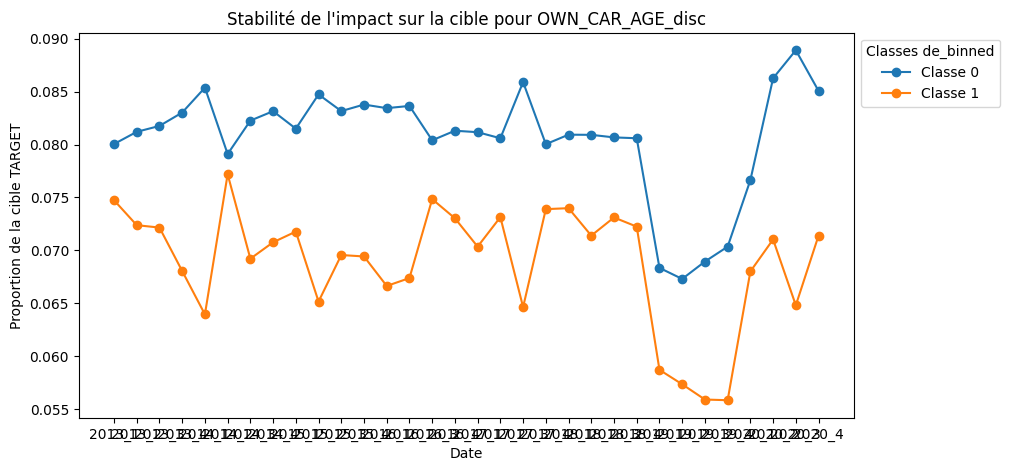

 25%|██▌       | 1/4 [00:29<01:27, 29.04s/it]

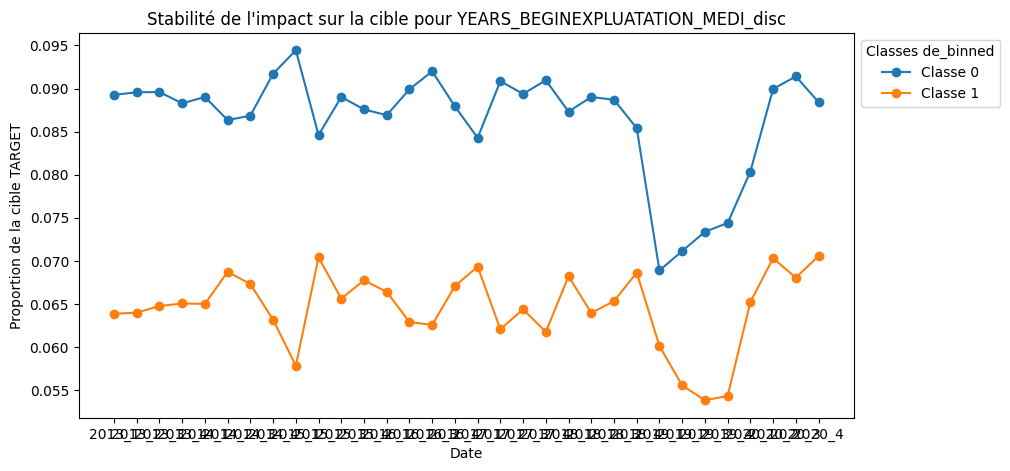

 50%|█████     | 2/4 [00:58<00:58, 29.37s/it]

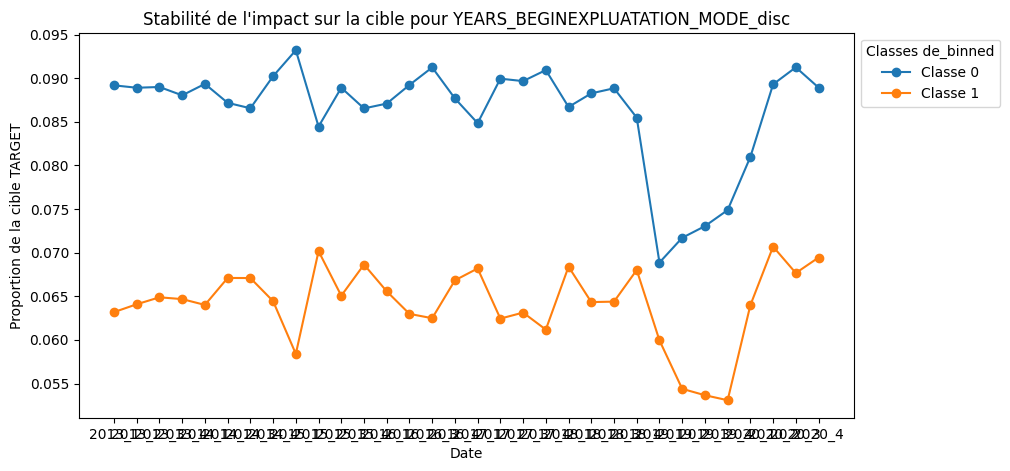

 75%|███████▌  | 3/4 [01:27<00:29, 29.09s/it]

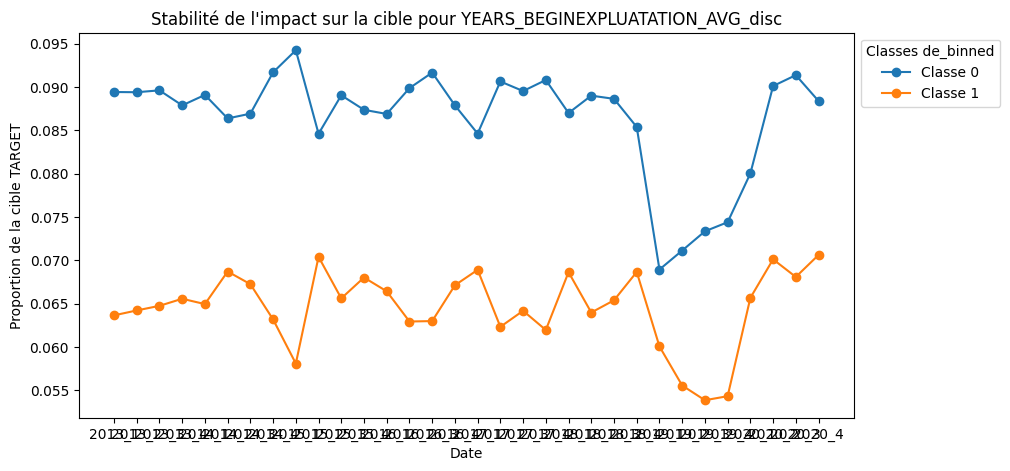

100%|██████████| 4/4 [01:56<00:00, 29.17s/it]


In [113]:
tr, te = dis.run_discretisation()